In [11]:
import random
import csv
import time
from datetime import datetime, timedelta

def generate_traffic_data(number_of_rows):
    pages = ['/home', '/about' , '/contact', '/services']
    countries = ['US', 'India', 'Aus' , 'Phill', 'Swiss']
    devices = ['mobile', 'desktop', 'tablet']
    data = []

    for _ in range(number_of_rows):
        timestamp = datetime.now() - timedelta(seconds=random.randint(0, 86400))
        user_id = random.randint(10001, 99999)
        page_url = random.choice(pages)
        session_duration = random.randint(100, 300)
        country = random.choice(countries)
        device = random.choice(devices)
        data.append([timestamp.strftime('%Y-%m-%d %H:%M:%S'), user_id ,page_url, session_duration, country, device])
    return data

with open('web_traffic.csv', mode = 'w', newline = '') as file:
    writer = csv.writer(file)
    writer.writerow(['timestamp', 'user_id', 'page_url', 'session_duration', 'country', 'device'])
    writer.writerows(generate_traffic_data(1000))

In [1]:
# read csv file using spark
from pyspark.sql import SparkSession
spark = SparkSession.builder\
          .getOrCreate()
spark

df = spark.read.csv('web_traffic.csv', header = True)
df.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- page_url: string (nullable = true)
 |-- session_duration: string (nullable = true)
 |-- country: string (nullable = true)
 |-- device: string (nullable = true)



In [2]:
# Transformation Data Structuring (Preprocessing)
# convert user id into int, timestamp into timestamp, session duration into int
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, BooleanType, DataType

df_new = df.withColumn('user_id', col('user_id').cast('int'))\
.withColumn('timestamp', col('timestamp').cast('timestamp'))\
.withColumn('session_duration', col('session_duration').cast('integer'))
df_new.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- page_url: string (nullable = true)
 |-- session_duration: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- device: string (nullable = true)



In [3]:
# Transfomration (business logic)
from pyspark.sql import Window, types
from pyspark.sql.functions import rank, dense_rank


# rank users based on session_duration
# withColumn behaves as => 'RANK() OVER() AS NEW_COL

df_new.withColumn('user_rank', dense_rank().over(Window.orderBy('session_duration'))).show()
# df_new.withColumn('user_id', dense_rank().over(Window.orderBy('session_duration'))).show()

+-------------------+-------+---------+----------------+-------+-------+---------+
|          timestamp|user_id| page_url|session_duration|country| device|user_rank|
+-------------------+-------+---------+----------------+-------+-------+---------+
|2025-04-07 06:17:35|  68160|/services|             100|  India|desktop|        1|
|2025-04-06 21:22:58|  30242|   /about|             100|  Phill| mobile|        1|
|2025-04-07 01:48:56|  26639|    /home|             101|    Aus| mobile|        2|
|2025-04-07 12:41:45|  83704| /contact|             101|     US|desktop|        2|
|2025-04-06 19:43:57|  11156|    /home|             101|  Swiss| mobile|        2|
|2025-04-07 07:58:57|  27259| /contact|             101|  Swiss|desktop|        2|
|2025-04-06 16:10:14|  59902| /contact|             101|  Swiss|desktop|        2|
|2025-04-07 11:30:35|  30179|   /about|             102|    Aus| mobile|        3|
|2025-04-06 19:15:06|  20931|    /home|             102|    Aus| mobile|        3|
|202

In [4]:
# count number of users in each country
df_new.groupBy('country').count().show()

# count users based on devvice
df_new.groupBy('device').count().withColumnRenamed('count','users per device').show()
# df_new.groupBy('device').count().withColumn(col('count'), 'users per device').show() -- wrong use of withColumn

+-------+-----+
|country|count|
+-------+-----+
|  Swiss|  211|
|  Phill|  170|
|  India|  207|
|    Aus|  204|
|     US|  208|
+-------+-----+

+-------+----------------+
| device|users per device|
+-------+----------------+
|desktop|             318|
| mobile|             324|
| tablet|             358|
+-------+----------------+



In [5]:
# most visited page url
df_new.show(5)
df_new.groupBy('page_url').count().alias('visits').show()

df_new.groupBy('page_url').count().withColumnRenamed('count', 'visits').orderBy(col('visits'), ascending = False).limit(1).show()

+-------------------+-------+---------+----------------+-------+-------+
|          timestamp|user_id| page_url|session_duration|country| device|
+-------------------+-------+---------+----------------+-------+-------+
|2025-04-07 09:01:48|  70457|    /home|             263|  Swiss|desktop|
|2025-04-07 07:42:07|  69876|/services|             221|  India| tablet|
|2025-04-07 02:00:48|  67400|   /about|             296|  Swiss|desktop|
|2025-04-07 03:26:08|  52613|/services|             113|  Phill| tablet|
|2025-04-07 13:12:08|  99873| /contact|             248|     US| mobile|
+-------------------+-------+---------+----------------+-------+-------+
only showing top 5 rows

+---------+-----+
| page_url|count|
+---------+-----+
|   /about|  222|
|    /home|  262|
|/services|  266|
| /contact|  250|
+---------+-----+

+---------+------+
| page_url|visits|
+---------+------+
|/services|   266|
+---------+------+



In [6]:
# most active user
# df_new.groupBy('country').max('session_duration').alias('last active user').show() 
df_new.groupBy('country').max('session_duration').alias('last_active_user').show()

+-------+---------------------+
|country|max(session_duration)|
+-------+---------------------+
|  Swiss|                  299|
|  Phill|                  299|
|  India|                  300|
|    Aus|                  299|
|     US|                  300|
+-------+---------------------+



In [7]:
# last active user based on timestamp
df_new.orderBy('timestamp', ascending = False).limit(1).show()

+-------------------+-------+--------+----------------+-------+------+
|          timestamp|user_id|page_url|session_duration|country|device|
+-------------------+-------+--------+----------------+-------+------+
|2025-04-07 15:25:19|  77275|/contact|             130|  Swiss|mobile|
+-------------------+-------+--------+----------------+-------+------+



In [40]:
# store data into tables(temporary or global temporary view)
df_new.createOrReplaceTempView('web_traffic')
spark.sql('select * from web_traffic limit 10').show()
spark.sql("select count(user_id) from web_traffic where country not in ('India') and device = 'desktop'").show()

+-------------------+-------+---------+----------------+-------+-------+
|          timestamp|user_id| page_url|session_duration|country| device|
+-------------------+-------+---------+----------------+-------+-------+
|2025-04-07 09:01:48|  70457|    /home|             263|  Swiss|desktop|
|2025-04-07 07:42:07|  69876|/services|             221|  India| tablet|
|2025-04-07 02:00:48|  67400|   /about|             296|  Swiss|desktop|
|2025-04-07 03:26:08|  52613|/services|             113|  Phill| tablet|
|2025-04-07 13:12:08|  99873| /contact|             248|     US| mobile|
|2025-04-07 01:48:56|  26639|    /home|             101|    Aus| mobile|
|2025-04-06 15:33:39|  30473| /contact|             205|  Swiss| tablet|
|2025-04-06 18:18:40|  37630|    /home|             250|  Phill| mobile|
|2025-04-07 06:37:05|  57201|   /about|             170|     US|desktop|
|2025-04-06 18:41:05|  45106|   /about|             149|  Phill| mobile|
+-------------------+-------+---------+------------

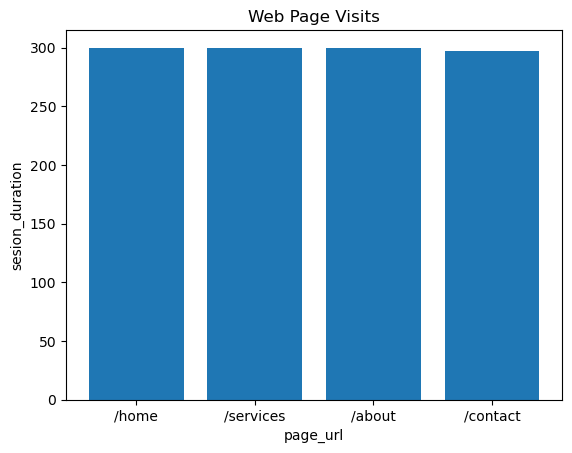

Text(0.5, 1.0, 'Web Page Visits')

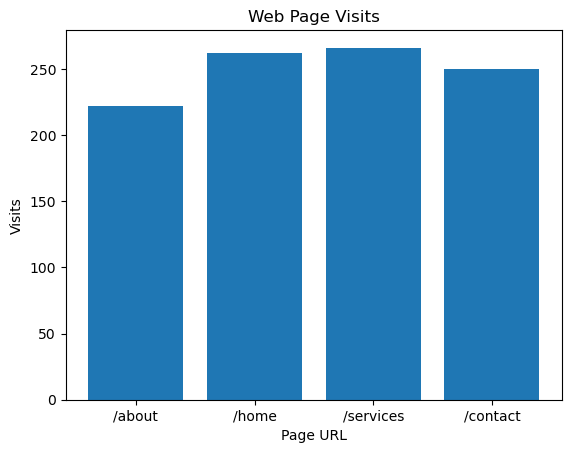

In [33]:
# visualize
import matplotlib
import matplotlib.pyplot as plt
pdf_new = df_new.toPandas()
pdf_new

# pdf_new.plot(kind = 'barh', x = 'user_id', y='session_duration')

plt.bar(pdf_new['page_url'], pdf_new['session_duration'])  # Vertical bars by default
plt.xlabel("page_url")
plt.ylabel("sesion_duration")
plt.title("Web Page Visits")
plt.show()

df_visits = df_new.groupBy('page_url').count().withColumnRenamed('count', 'visits')
pdf_visits = df_visits.toPandas()

plt.bar(pdf_visits['page_url'], pdf_visits['visits'])
plt.xlabel("Page URL")
plt.ylabel("Visits")
plt.title("Web Page Visits")

Text(0.5, 1.0, 'Users per Device')

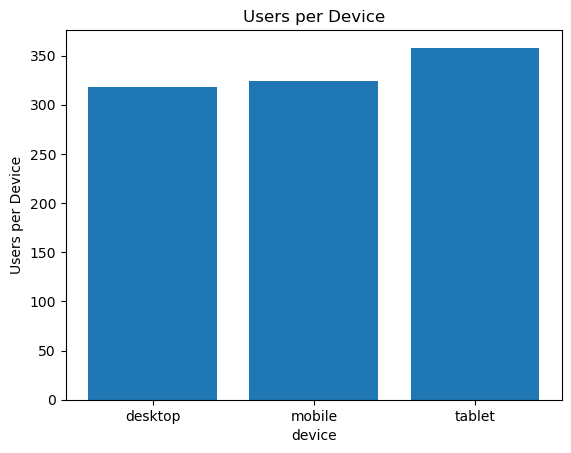

In [32]:
df_devices = df_new.groupBy('device').count().withColumnRenamed('count','users per device')
pdf_devices = df_devices.toPandas()


plt.bar(pdf_devices['device'], pdf_devices['users per device'])
plt.xlabel('device')
plt.ylabel('Users per Device')
plt.title('Users per Device')